# Introduction
"New York City has published data on [student SAT scores](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) by high school, along with additional demographic data sets. Previously, the following data sets were combined into a single dataframe:

- [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair."

The dataframe will be used to analyze how fair the SAT test is based on demographic factors

# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)
type(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

pandas.core.series.Series

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

### Part I - Introduction

In [11]:
#1
import matplotlib.pyplot as plt

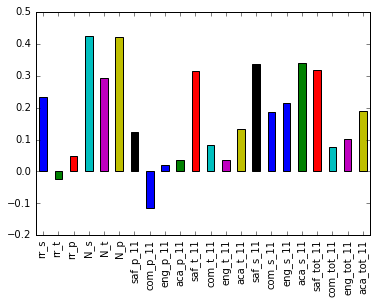

In [12]:
#2
%matplotlib inline  
correlations[survey_fields].plot.bar()

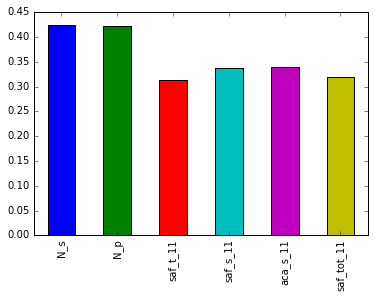

In [13]:
#3 and #4
correlations[survey_fields][~correlations[survey_fields].between(-.3,.3)].plot.bar()

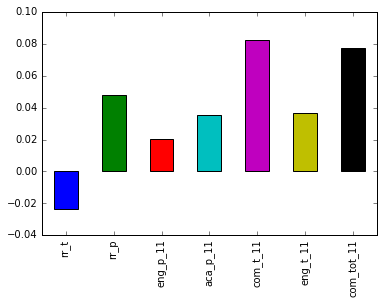

In [14]:
#3 and #4
correlations[survey_fields][correlations[survey_fields].between(-.1,.1)].plot.bar()

\#3 and \#4
- higher correlation values (>|30%|) include N_s, N_t, saf_t_11, saf_s_11, aca_s_11 and saf_tot_11
- the maximum correlation between sat scores and the survey of parents, teachers and students don't exceed |50%|
- lower correlation values (<|10%|) include rr_t, rr_p, eng_p_11, aca_p_11, com_t_11, eng_t_11 and com_tot_11
- no values have zero correlations, however some are very low

### Part II - Exploring Safety and SAT Scores

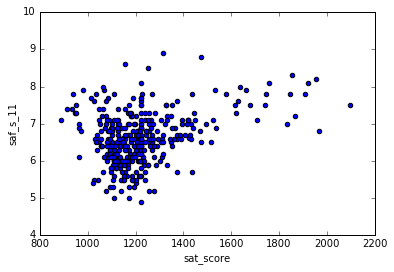

In [15]:
#1
combined.plot.scatter(y='saf_s_11', x='sat_score')

\#1
- in the SAT score range of 800-1300 the correlation with the safety of students survey is weak because there is no apparent trend
- in the range from 1300 and above there is a positive correlation beteween the SAT score and the student survey rating for safety

In [16]:
#2
sd_mean=combined.groupby('school_dist').mean()

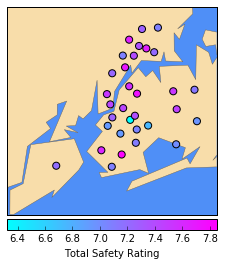

In [17]:
#2 
#from step 2 course 6 lesson 3 slide 12
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

#colors - https://htmlcolorcodes.com/
m.drawmapboundary(fill_color='#4F8FF7')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#2779FE', linewidth=.4)
#continents - https://matplotlib.org/basemap/users/examples.html
m.fillcontinents(color='#F8DDAA')


longitudes=sd_mean['lon'].tolist()
latitudes=sd_mean['lat'].tolist()

#spectrums - https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
m.scatter(longitudes,latitudes, s=50,zorder=2,latlon=True,c=sd_mean['saf_tot_11'],cmap='cool')
#colorbar - https://basemaptutorial.readthedocs.io/en/latest/plotting_data.html
m.colorbar(location='bottom', label='Total Safety Rating')

plt.show()

In [18]:
#2
print(sd_mean['saf_tot_11'].min())
print(sd_mean['saf_tot_11'].max())
print(sd_mean['saf_tot_11'].mean())

6.325000000000001
7.85
7.282955967643468


In [19]:
sorted_mean=sd_mean['saf_tot_11'].sort_values(ascending=False)
print('5 Most Safe Disctricts and Safety Rating : ' + str(sorted_mean[:5]))
print('5 Least Safe Disctricts and Safety Rating : ' + str(sorted_mean[-5:]))

5 Most Safe Disctricts and Safety Rating : school_dist
22    7.850000
24    7.753846
04    7.714286
12    7.666667
06    7.660000
Name: saf_tot_11, dtype: float64
5 Least Safe Disctricts and Safety Rating : school_dist
29    6.962500
17    6.935714
15    6.933333
19    6.758333
16    6.325000
Name: saf_tot_11, dtype: float64


\#2
- the first step was getting a general feel from the map generated above
- secondly, use google maps and other maps to located the neighborhood of the most safe and least safe neighborhoods
- third, evaluate the neighborhood using metrics such as econometrics, crime rate, health and demographics as well as reading on the general feel of the neighborhoods

### Part III - Exploring Race and SAT Scores

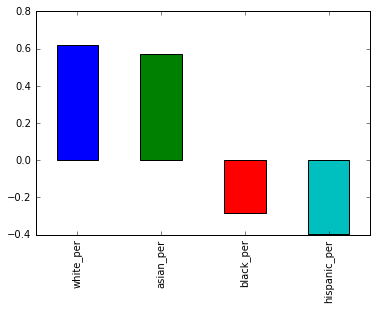

In [21]:
#1
correlations[['white_per','asian_per','black_per','hispanic_per']].plot.bar()

\#1
- the percentage of white and asian SAT takers has a strong positive correlation with the SAT score
- the percentage of black and hispanic SAT takers has a negative correlation with the SAT score

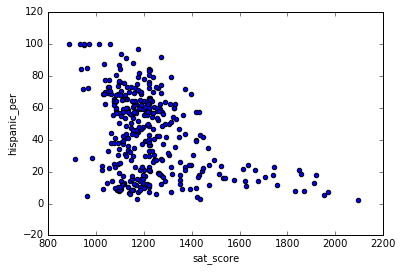

In [24]:
#2
combined.plot.scatter(x='sat_score',y='hispanic_per')

\#2
- there is a general negative trend
- All SAT scores above ~1500 has a hispanic percentage lower than 30%

In [25]:
#3
combined[combined['hispanic_per']>95]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0,0,0,0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0,0,0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0,0,0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0,0,0,0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",40.743303,-73.870575,24


\#3
- it appears that most schools are tailed to bilingual families who are new to the US
    - [Manhattan Bridges High School](https://insideschools.org/school/02M542) are said to mainly serve Spanish immigrants
    - [Multicultural High School](https://insideschools.org/school/19K583) also serves students who have been in the US for less than 3 years and are Spanish-speaking
- to a lot of students in these schools English is not their main language and the language barrier most likely negatively impacts their performance on the SAT

In [35]:
#4
lowhp_highsat=combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]
print(lowhp_highsat['SCHOOL NAME'])
lowhp_highsat[['white_per','asian_per','black_per','hispanic_per']]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


,white_per,asian_per,black_per,hispanic_per
37,23.7,72.1,1.2,2.4
151,25.4,63.5,3.5,7.2
187,21.3,60.3,10.2,7.9
327,6.7,74.4,10.5,7.9
356,61.3,31.8,1.1,5.3


\#4
- many high schools in NYC are specialized and have an entrance exam
- they are also ranked in the [top 10 high schools in NYC](https://www.usnews.com/education/best-high-schools/new-york)

### Part IV - Exploring Gender and SAT Scores

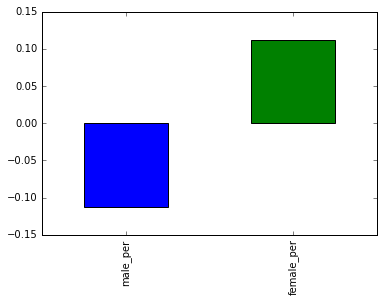

In [36]:

correlations[['male_per','female_per']].plot.bar()

\#1
- both correlations are relatively weak
- males have a negative correlation (~ -0.1), while females have a positive correlations (~ 0.1)

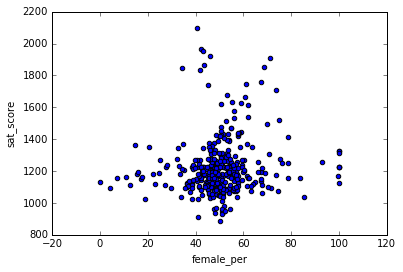

In [37]:
#2
combined.plot.scatter(x='female_per',y='sat_score')

\#2
- the genral band of SAT scores between around 900-1400 have all percentages of females
- the higher SAT scores between around 1400-2200 have female percentages from around 35-80%
- it is difficult to visualize a general trend

In [41]:
#3
combined[(combined['female_per']>60) & (combined['sat_score']>1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

\#3
- most of these schools are liberal arts schools and have selective admission based on exams or auditions

### Part V - Exploring AP Scores and SAT Scores

In [45]:
#1
ap_per=combined['AP Test Takers ']/combined['total_enrollment']

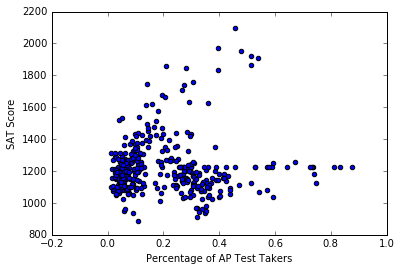

In [49]:
#2
plt.scatter(x=ap_per, y=combined['sat_score'])
plt.xlabel('Percentage of AP Test Takers')
plt.ylabel('SAT Score')

\#2
- there seems to be two trends
    - one does have a positive correlation between the SAT score and percentage of AP test takers between 0 and 60%
    - there is also a no correlation trend where the SAT score does not increase with the percentage of AP test takers

More analysis is possible is needed